# Packages, dataset, and variable names

In [26]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Datasets
train = pd.read_csv('train.csv').drop(columns='Id')
test = pd.read_csv('test.csv').drop(columns='Id')

# Variables
response = ['price']

categorical = ['host_is_superhost', 'host_identity_verified', 'property_type', 'room_type',
               'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

continuous = ['host_total_listings_count', 'security_deposit', 'cleaning_fee', 'extra_people',
              'minimum_nights','maximum_nights']

discrete = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

reviews = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
           'review_scores_location', 'review_scores_value', 'reviews_per_month']

coordinates = ['latitude', 'longitude']

predictors = categorical + continuous + discrete + reviews + coordinates

# EDA
No EDA in this Notebook - see previous notebooks

# Data Processing / Engineering / Scaling

In [56]:
def impute(data):
    '''
    Imputes missing data in test / train sets for Airbnb data
    '''
    
    # Categoricals
    data['host_is_superhost'].fillna(value='f', inplace=True)
    data['host_identity_verified'].fillna(value='f', inplace=True)

    # No costs
    data['security_deposit'].fillna(value=0, inplace=True)
    data['cleaning_fee'].fillna(value=0, inplace=True)

    # Medians
    for i in discrete+continuous:
        data[i].fillna(value=np.nanmedian(data[i]), inplace=True)

    # Reviews
    zero_reviews = data[reviews].loc[data['number_of_reviews'] == 0]
    zero_reviews.fillna(value=0, inplace=True)

    nonzero_reviews = data[reviews].loc[data['number_of_reviews'] > 0]
    data_reviews = pd.concat([zero_reviews, nonzero_reviews], axis=0).sort_index()

    for i in data_reviews.columns:
        data_reviews[i].fillna(value=np.nanmedian(data_reviews[i]), inplace=True)

    data = data.drop(columns=data[reviews].columns)
    data = pd.concat([data, data_reviews], axis=1)
    
    return data

from math import radians, cos, sin, asin, sqrt

def great_circle_dist(lat1, lon1, lat2, lon2):
    '''
    Function to calculate distance between two points, using Haversine formula (used in engineering)
    '''
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    km = 6371 * c
    return km

def engineer(data):
    '''
    Feature engineering (encoding, transforming, and creating new variables)
    '''
    
    # One-hot encoding
    dummies = pd.get_dummies(data[categorical], columns=categorical, drop_first=True)
    data = data.drop(columns=data[categorical].columns)
    data = pd.concat([data, dummies], axis=1)

    # New predictors
    data['has_review'] = (data.number_of_reviews > 0).astype(int)
    data['fee_per_person'] = (data['security_deposit'] + data['cleaning_fee']) / data['accommodates']
    data['beds_per_person'] = data['beds'] / data['accommodates']
    data['bathrooms_per_person'] = data['bathrooms'] / data['accommodates']
    data['bedrooms_per_person'] = data['bedrooms'] / data['accommodates']
    data['beds_per_bedrooms'] = data['beds'] / data['bedrooms']

    review_combination = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication', 'review_scores_location', 'review_scores_value']
    data['average_review'] = data[review_combination].mean(axis=1)
    
    # Interactions
    data['security_deposit:is_business_tavel_ready'] = data['security_deposit'] * data['is_business_travel_ready_t']
    data['security_deposit:host_identity_verified'] = data['security_deposit'] * data['host_identity_verified_t']
    data['review_scores_rating:instant_bookable'] = data['review_scores_rating'] * data['instant_bookable_t']
    
    # Distance (using great circle distance)
    syd_lat, syd_lon = -33.8587377, 151.210686 # Syd Opera House

    distance = []
    for i in np.arange(len(data)):
        lat = data['latitude'].iloc[i]
        lon = data['longitude'].iloc[i]

        dist = great_circle_dist(syd_lat, syd_lon, lat, lon)
        distance.append(dist)

    distance = pd.DataFrame(distance, columns=['distance'])
    data = pd.concat([data, distance], axis=1)

    # Logs (determined with EDA on distributions)
    pred_to_log = ['security_deposit', 'cleaning_fee', 'minimum_nights', 'maximum_nights',
                   'number_of_reviews', 'reviews_per_month', 'fee_per_person', 'distance']
    for i in pred_to_log:
        data[str('log_')+i] = np.log(data[i])
 
    # Data to drop / uncomment if more useful removed
    #data = data.drop(columns=review_combination)
    #data = data.drop(columns=coordinates)
    #data = data.drop(columns=pred_to_log)
    try:
        data = data.drop(columns='property_type_Timeshare') # doesn't exist in test dataset
    except:
        pass

    # Necessary due to new predictors and logging
    data = data.replace([np.inf, -np.inf], 0)
    data = data.replace([np.nan], 0)
    
    return data

def process(data):
    data = impute(data)
    data = engineer(data)
    
    return data

In [57]:
# 1. Run processing
train_processed = process(train)
test_processed = process(test)

response = 'price'
predictors = [x for x in list(train_processed.columns) if x not in response]

# 2. Get the scaler for scaling train / test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_processed[predictors])

# 3. Scaler for train / test
def scaling(data):
    data_scaled = scaler.transform(data[predictors])
    data = pd.DataFrame(data_scaled, columns=predictors)
    
    return data

# 4. Scale and split
X_train = scaling(train_processed)
y_train = np.log(train_processed['price']) # logged

X_test = scaling(test_processed)

# Models

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [59]:
from sklearn.model_selection import cross_val_score
def score(method):
    '''
    Function to return RMSE for model
    '''
    score = np.mean(np.sqrt(-cross_val_score(method, X_train, y_train, scoring='neg_mean_squared_error', cv=5)))
    print('RMSE: {}'.format(score))

### Linear Regression + KNN

In [60]:
ols = LinearRegression()
ols.fit(X_train, y_train)

score(ols)

RMSE: 567887932176.9563


In [61]:
%%time
model = KNeighborsRegressor() 
    
tuning_parameters = {
    'n_neighbors': np.arange(1, 51),
}

knn_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)
knn_search.fit(X_train, y_train)
knn = knn_search.best_estimator_

score(knn)
print('Best parameters: {}'.format(knn_search.best_params_))

RMSE: 0.42898635934600626
Best parameters: {'n_neighbors': 12}
Wall time: 5.14 s


### Lasso

In [62]:
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

score(lasso)

RMSE: 0.37478601291661995


### Ridge

In [63]:
alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

score(ridge)

RMSE: 0.3752215750459422


### Elastic Net

In [64]:
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

score(enet)

RMSE: 0.37498584122671297


### Regression Tree

In [65]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20],
    'max_depth': np.arange(1, 30),
}

#tree_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
tree_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)
tree_search.fit(X_train, y_train)
tree = tree_search.best_estimator_

score(tree)
print('Best parameters:', tree_search.best_params_)

RMSE: 0.4039906856992347
Best parameters: {'max_depth': 3, 'min_samples_leaf': 5}
Wall time: 4.95 s


### Bagging

In [66]:
%%time

bag = BaggingRegressor(n_estimators=500, random_state=1)
bag.fit(X_train, y_train)
score(bag)

RMSE: 0.37424727348342124
Wall time: 26.4 s


### Random Forest

In [67]:
%%time

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

#rf_search = RandomizedSearchCV(model, tuning_parameters, cv=5, n_iter=16, return_train_score=False, n_jobs=4, random_state=1)
rf_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'max_features': 61, 'min_samples_leaf': 5} 

Wall time: 2min 57s


In [68]:
rf.n_estimators = 500
rf.fit(X_train, y_train)
score(rf)

RMSE: 0.3745677348412326


### Boosting

In [69]:
%%time
model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
#gb = GridSearchCV(model, tuning_parameters, cv=10, return_train_score=False, n_jobs=1)
gb_search.fit(X_train, y_train)

print('Best parameters found by grid search:', gb_search.best_params_, '\n')

Best parameters found by grid search: {'subsample': 0.6, 'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.01} 

Wall time: 2min 19s


In [70]:
gb = gb_search.best_estimator_
score(gb)

RMSE: 0.36384417133820907


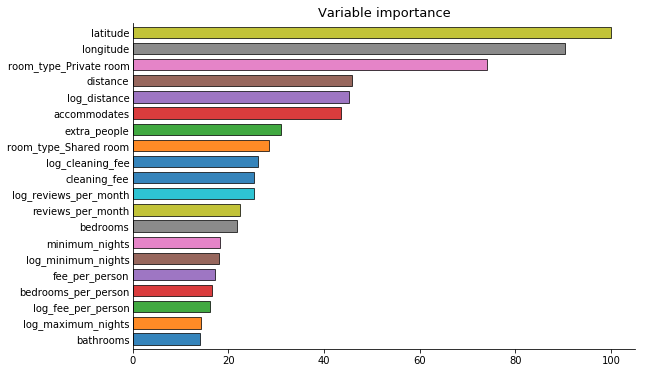

In [71]:
from statlearning import plot_feature_importance

plot_feature_importance(gb, predictors)
plt.show()

### XGBoost

In [72]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
#gb = GridSearchCV(model, tuning_parameters, cv=10, return_train_score=False, n_jobs=1)
gb_search.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.01} 

Wall time: 2min 12s


In [73]:
xbst = gb_search.best_estimator_
score(xbst)

RMSE: 0.36282142119985555


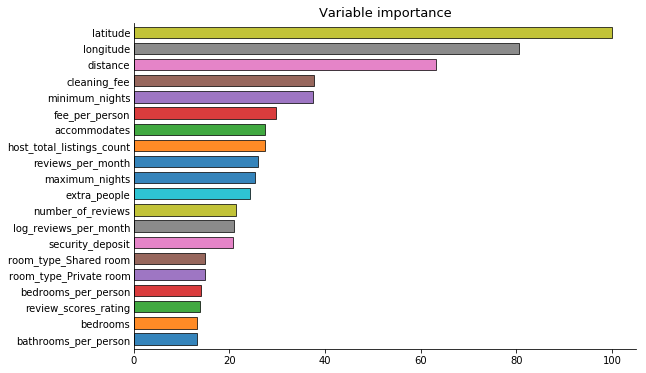

In [74]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

In [75]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 2, 
    'learning_rate': 0.1, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round=1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

Selected number of boosting iterations: 137
RMSE (CV): 0.3617
Wall time: 5.58 s


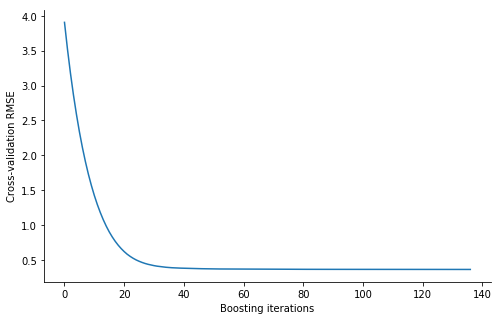

In [76]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

### LightGBM

In [77]:
%%time

model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=50, cv=10, return_train_score=False, n_jobs=1, random_state=1)
gb_search.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01} 

Wall time: 4min 43s


In [78]:
lbst = gb_search.best_estimator_
score(lbst)

RMSE: 0.3824390774302887


### Adaptive Boosting

In [79]:
%%time

y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
gb_search.fit(X_train, resid)

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.01} 

Wall time: 59.3 s


In [80]:
abst = gb_search.best_estimator_
score(abst)

RMSE: 0.3950857263919705


### Model Stacking

In [82]:
%%time

models = [lasso, bag, gb, xbst] # four best
#models = [lasso, abst, xbst] # Cindy's
stack = StackingCVRegressor(models, meta_regressor=LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

Wall time: 3min 58s


# Prediction

In [83]:
y_pred = np.exp(stack.predict(X_test.values))
submission = pd.DataFrame(np.c_[X_test.index, y_pred], columns=['Id', 'price'])
submission.to_csv('kaggle_submission.csv',  index=False)

# Keras MLP (NOT UPDATED)

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau

In [84]:
train_processed = process(train)
test_processed = process(test)

X_train = scaling(train_processed)
y_train = train_processed['price']
X_test = scaling(test_processed)

In [89]:
model = Sequential()

model.add(Dense(len(X_train.columns), input_dim=len(X_train.columns),
                kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'acc'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model.fit(X_train, y_train, epochs=100, batch_size=10, callbacks=[reduce_lr])

Epoch 1/100
1000/1000 [==============================] - 15s 15ms/step - loss: 29390.1059 - mean_squared_error: 29390.1059 - acc: 0.0000e+00
Epoch 2/100
1000/1000 [==============================] - 15s 15ms/step - loss: 26581.5765 - mean_squared_error: 26581.5765 - acc: 0.0000e+00
Epoch 3/100
1000/1000 [==============================] - 15s 15ms/step - loss: 16556.7537 - mean_squared_error: 16556.7537 - acc: 0.0000e+00
Epoch 4/100
1000/1000 [==============================] - 15s 15ms/step - loss: 8164.8428 - mean_squared_error: 8164.8428 - acc: 0.0070
Epoch 5/100
1000/1000 [==============================] - 14s 14ms/step - loss: 5846.1857 - mean_squared_error: 5846.1857 - acc: 0.0060
Epoch 6/100
1000/1000 [==============================] - 13s 13ms/step - loss: 4806.8824 - mean_squared_error: 4806.8824 - acc: 0.0060
Epoch 7/100
1000/1000 [==============================] - 14s 14ms/step - loss: 4270.7021 - mean_squared_error: 4270.7021 - acc: 0.0050
Epoch 8/100
1000/1000 [==============

In [91]:
# Prediction
y_pred = model.predict(X_test, batch_size=10)
submission = pd.DataFrame(np.c_[X_test.index, y_pred], columns=['Id', 'price'])
submission.to_csv('kaggle_submission.csv',  index=False)

# Extra EDA
Below is for helping determine what predictors to log-transform, as well as identify potential interactions

In [ ]:
# EDA to help determine logs
def hist(series):
    fig, ax = plt.subplots()
    sns.distplot(series, ax=ax,
                 hist_kws={'alpha': 0.75,
                           'edgecolor':'black',
                           'color': sns.color_palette('Greens')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.9})
    return plt.show()

for i in data.columns:
    hist(data[i])

In [ ]:
# Potential interactions?
sns.lmplot('security_deposit', 'price', data=data_temp, hue='is_business_travel_ready', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

sns.lmplot('security_deposit', 'price', data=data_temp, hue='host_identity_verified', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

sns.lmplot('review_scores_rating', 'price', data=data_temp, hue='instant_bookable', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()